# Photo-z data AugMent (PAM)

#### Setup:

Run `source setup.sh` from `bash` command line in kernel in order to setup paths for code.

## Create train/test catalogs

In [2]:
import os
import numpy as np
from create_cats import create_cats
%load_ext autoreload
%autoreload 2

### Create base catalog

In [3]:
# Catalog columns
names = ['redshift', 'u', 'g', 'r', 'i', 'z', 'y']

In [4]:
# Point to catalog
cat_name = 'brown_template_train.csv'
filename = os.path.join(os.environ['PZ_CAT_FOLDER'], cat_name)
cc = create_cats(filename, names)

Training set size: 500000. Test set size: -490841.


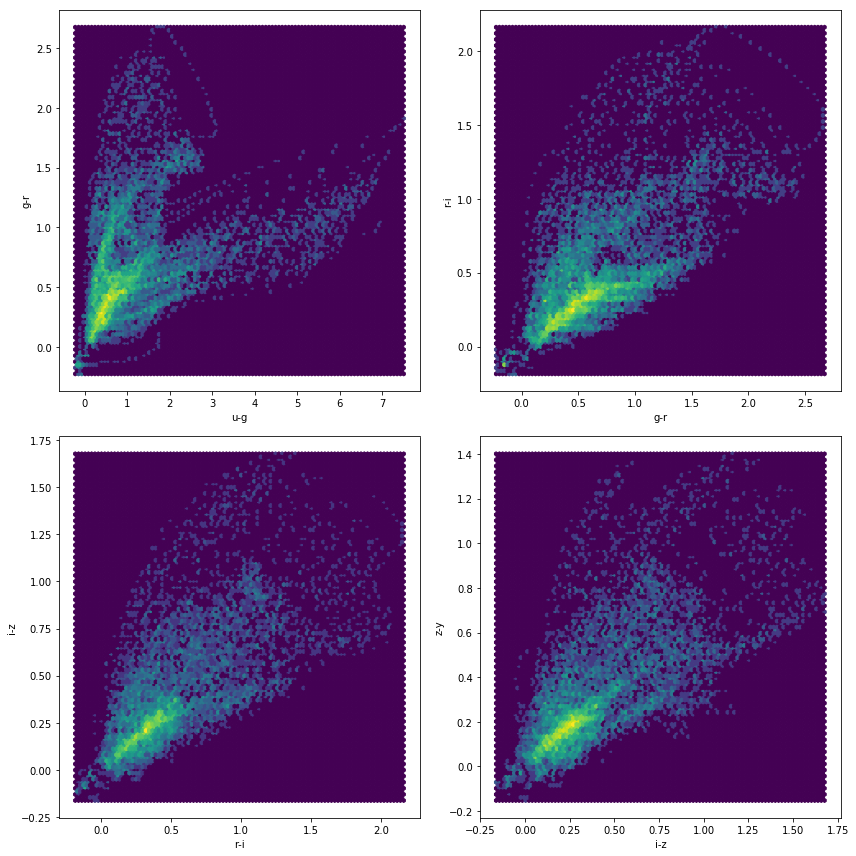

In [5]:
# Create a base train/test catalog with 500,000 objects in training set
# and remaining in test set
cc.create_base_cats('brown_full', 500000, out_dir='../data', random_state=2136)

### Create alternative catalogs

In [32]:
# Catalog columns
names = ['index', 'redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'g_abs', 'r_abs']

In [33]:
# Point to catalog
cat_name = 'Euclid_trim_27p5_3p5_short.dat'
filename = os.path.join(os.environ['PZ_CAT_FOLDER'], cat_name)
cc = create_cats(filename, names)

Color group histogram: 
(array([ 89042, 336619,  22396,  51943]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]))
Removing Color Group 0
Training set size: 410958. Test set size: 2000000.


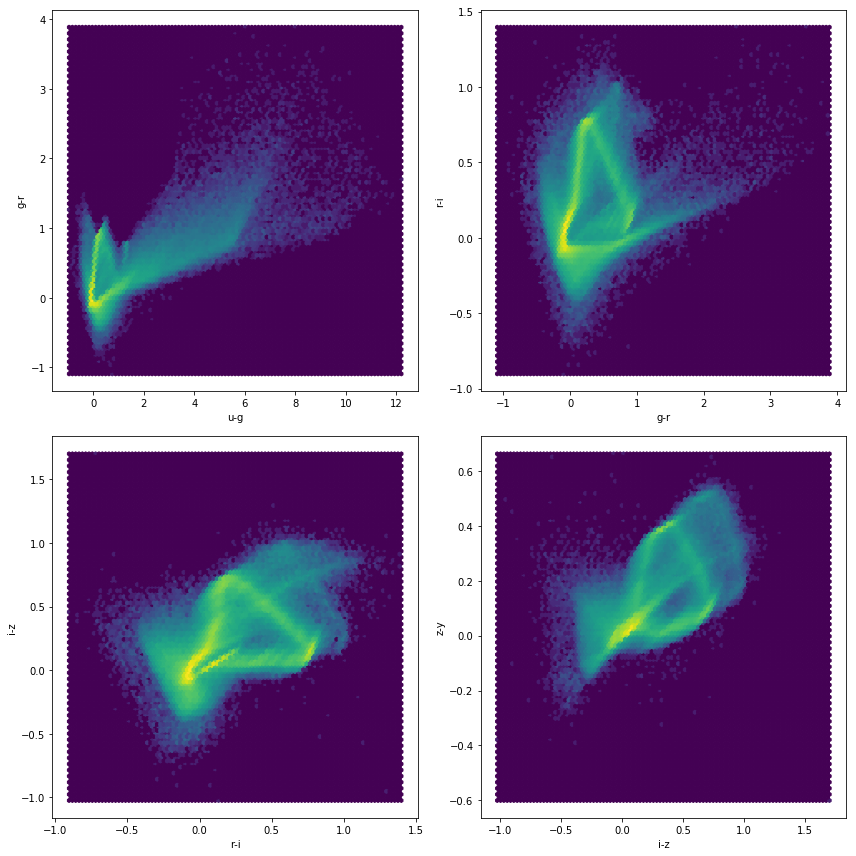

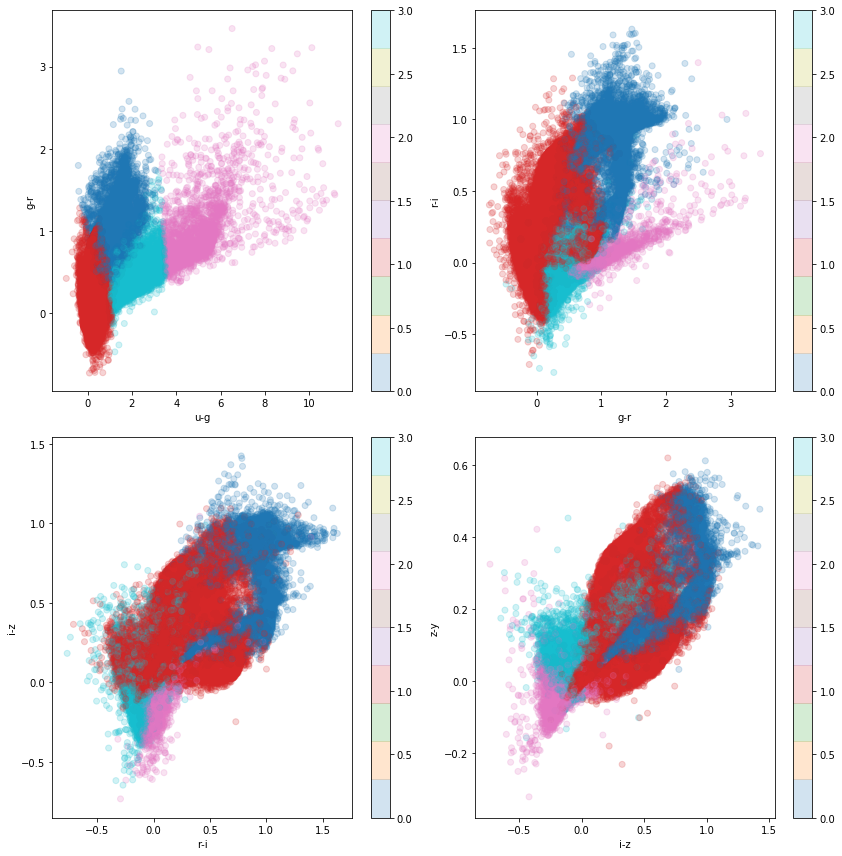

In [34]:
# Group color cut
cc.create_color_group_cats('4_group_color_cut_0', 500000, 4, choose_out=0, out_dir='../data', random_state=2136)

### Create combined catalog

In [29]:
brown_train_cat = pd.read_csv('../data/train_cat_brown_full.dat')
color_cut_train_cat = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')

In [30]:
combined_cat = pd.concat([brown_train_cat, color_cut_train_cat])

In [31]:
combined_cat.to_csv('../data/train_cat_combined.dat', index=False)

## Use ESP add catalog

In [51]:
# Point to catalog
cat_name = 'brown_esp_template_added_train.csv'
filename = os.path.join(os.environ['PZ_CAT_FOLDER'], cat_name)
cc = create_cats(filename, names)

Training set size: 500000. Test set size: -476242.


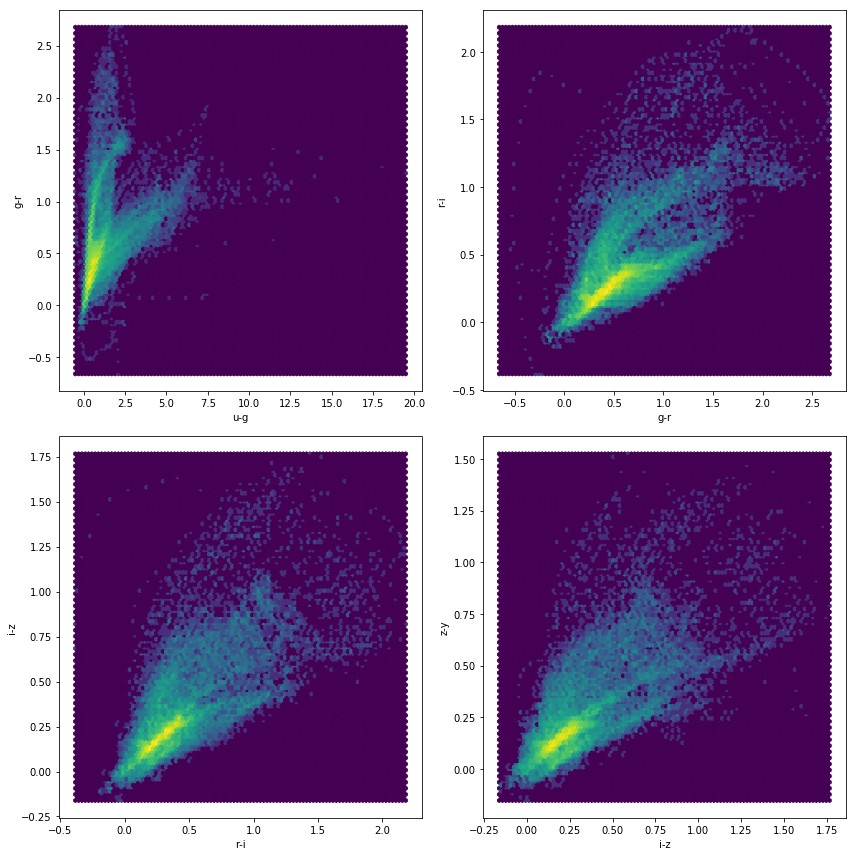

In [52]:
# Create a base train/test catalog with 500,000 objects in training set
# and remaining in test set
cc.create_base_cats('brown_esp', 500000, out_dir='../data', random_state=2136)

In [66]:
from sklearn.neighbors import NearestNeighbors

In [96]:
brown_train_cat = pd.read_csv('../data/train_cat_brown_full.dat')
color_cut_train_cat = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')

In [125]:
brown_train_cat = pd.read_csv('../data/train_cat_brown_esp.dat')
color_cut_train_cat = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')

In [126]:
brown_train_colors = brown_train_cat.values[:,1:-1] - brown_train_cat.values[:,2:]

In [127]:
color_cut_colors = color_cut_train_cat.values[:,1:-1] - color_cut_train_cat.values[:,2:]

In [128]:
neigh = NearestNeighbors(1)
neigh.fit(color_cut_colors)
dist, idx = neigh.kneighbors(brown_train_colors)

In [129]:
np.histogram(dist, bins=20)

(array([19494,  2845,   835,   369,   183,    27,     1,     0,     2,
            0,     0,     0,     0,     0,     0,     0,     1,     0,
            0,     1]),
 array([0.00917972, 0.37431719, 0.73945467, 1.10459214, 1.46972961,
        1.83486708, 2.20000455, 2.56514202, 2.9302795 , 3.29541697,
        3.66055444, 4.02569191, 4.39082938, 4.75596685, 5.12110432,
        5.4862418 , 5.85137927, 6.21651674, 6.58165421, 6.94679168,
        7.31192915]))

In [145]:
keep_idx = np.where((dist > 0.2) & (dist < 1.0))[0]
print(len(keep_idx), len(dist))

8349 23758


In [146]:
combined_cat = pd.concat([brown_train_cat.iloc[keep_idx], color_cut_train_cat])

In [147]:
combined_cat.to_csv('../data/train_cat_combined_cut_esp.dat', index=False)

## Train networks

In [21]:
import pandas as pd
from photoz_nn import photoz_nn

In [34]:
for train_suffix, test_suffix in zip(['brown_esp'],#, '4_group_color_cut_0', 'combined'],
                                     ['full']):#, 'full', 'full']):
    
    print(train_suffix)
    n_epochs = 500
    pz_nn = photoz_nn(seed=1446)

    train_filename = '../data/train_cat_%s.dat' % train_suffix
    train_colors, train_specz = pz_nn.load_catalog(train_filename)
    test_filename = '../data/test_cat_%s.dat' % test_suffix
    test_colors, test_specz = pz_nn.load_catalog(test_filename)

    train_len = len(train_colors)
    test_len = len(test_colors)

    net = pz_nn.train_model(train_colors, train_specz, n_epochs)

    train_colors, train_specz = pz_nn.load_catalog(train_filename)
    train_photoz = pz_nn.run_model(net, train_colors)
    test_photoz = pz_nn.run_model(net, test_colors)

    pz_nn.save_model(net, '../data/pz_network_%s.pt' % train_suffix)

    train_results = {'true_z':train_specz.reshape(train_len),
                     'photo_z': train_photoz.reshape(train_len)}
    train_results_df = pd.DataFrame.from_dict(data=train_results)
    test_results = {'true_z':test_specz.reshape(test_len),
                    'photo_z': test_photoz.reshape(test_len)}
    test_results_df = pd.DataFrame.from_dict(data=test_results)
    train_results_df.to_csv('../data/train_results_%s.csv' % train_suffix, index=False)
    test_results_df.to_csv('../data/test_results_%s.csv' % train_suffix, index=False)

brown_esp
Catalog size: 42386.
Catalog size: 2000000.
Net(
  (hidden_1): Linear(in_features=5, out_features=20, bias=True)
  (hidden_2): Linear(in_features=20, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)
After 20 epochs
tensor([-0.1181,  1.6039,  0.3109, -0.0471, -0.2909]) tensor([0.5141], grad_fn=<SelectBackward>) tensor([0.4500]) tensor(0.3460)
tensor([-0.6026, -0.2956,  0.2849,  1.4279,  0.8751]) tensor([1.2694], grad_fn=<SelectBackward>) tensor([1.2000]) tensor(0.3460)
After 40 epochs
tensor([-0.1181,  1.6039,  0.3109, -0.0471, -0.2909]) tensor([0.2191], grad_fn=<SelectBackward>) tensor([0.4500]) tensor(0.2231)
tensor([-0.6026, -0.2956,  0.2849,  1.4279,  0.8751]) tensor([1.3220], grad_fn=<SelectBackward>) tensor([1.2000]) tensor(0.2231)
After 60 epochs
tensor([-0.1181,  1.6039,  0.3109, -0.0471, -0.2909]) tensor([0.2007], grad_fn=<SelectBackward>) tensor([0.4500]) tensor(0.1925)
tensor([-0.6026, -0.2956,  0.2849,  1.4279,  0.8751]) 

## Plot results

In [35]:
from plot_pz_nn import plot_pz_nn

In [36]:
plot_pz = plot_pz_nn()

In [148]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined', 'combined_esp',
                   'brown_full', 'brown_esp', 'combined_cut', 'combined_cut_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

### Plot single results

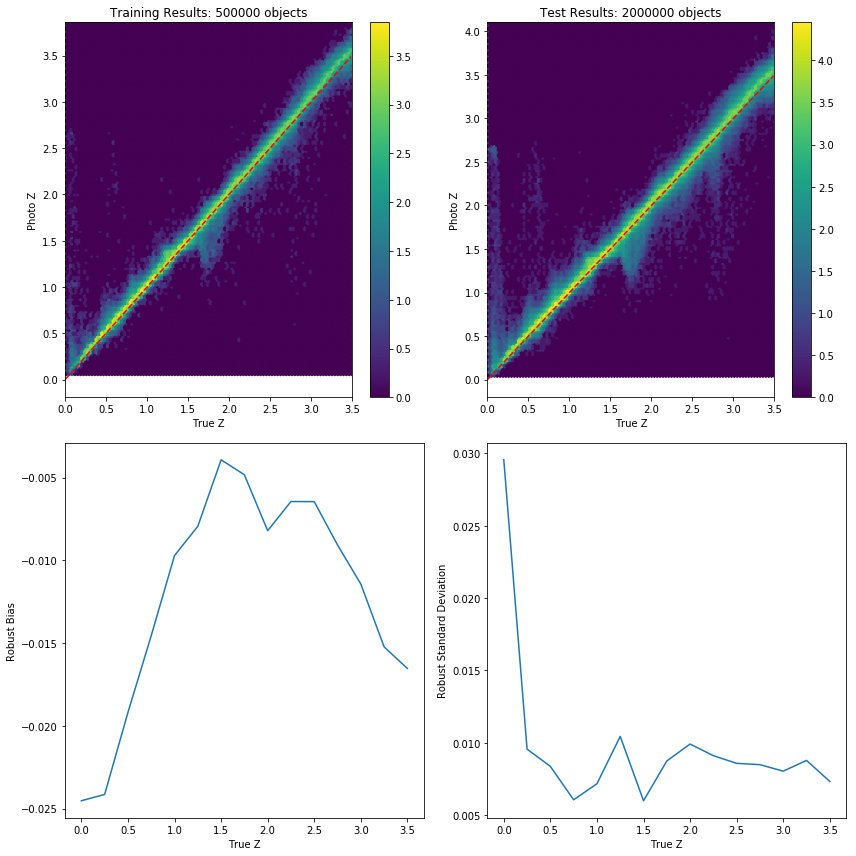

In [20]:
# full
cat_string = 'full'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

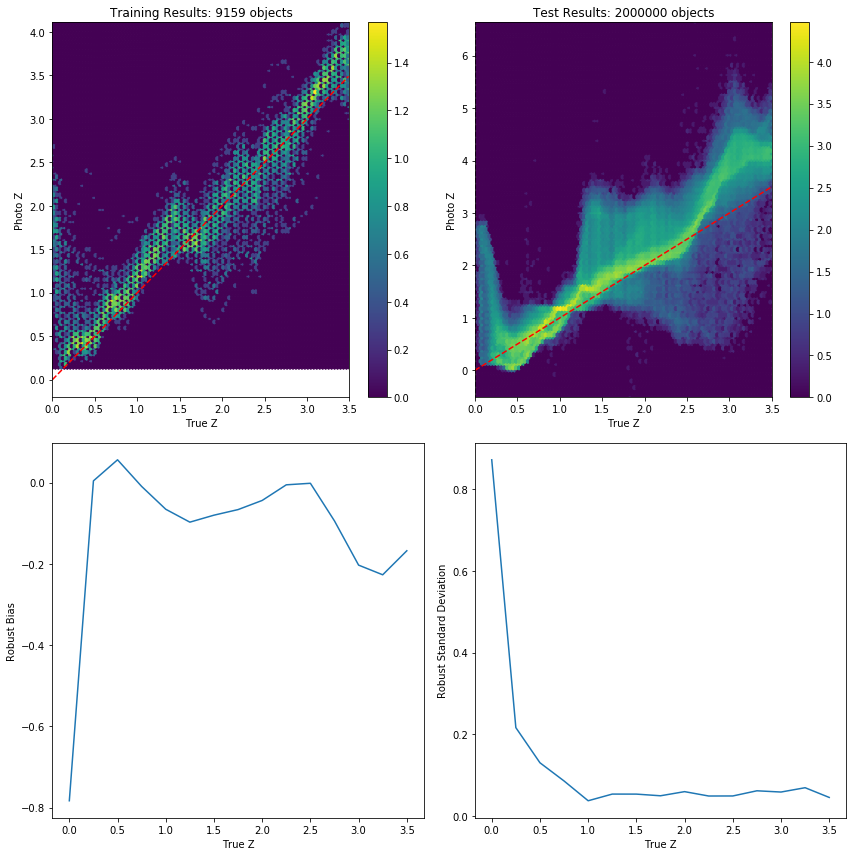

In [27]:
# full
cat_string = 'brown_full'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

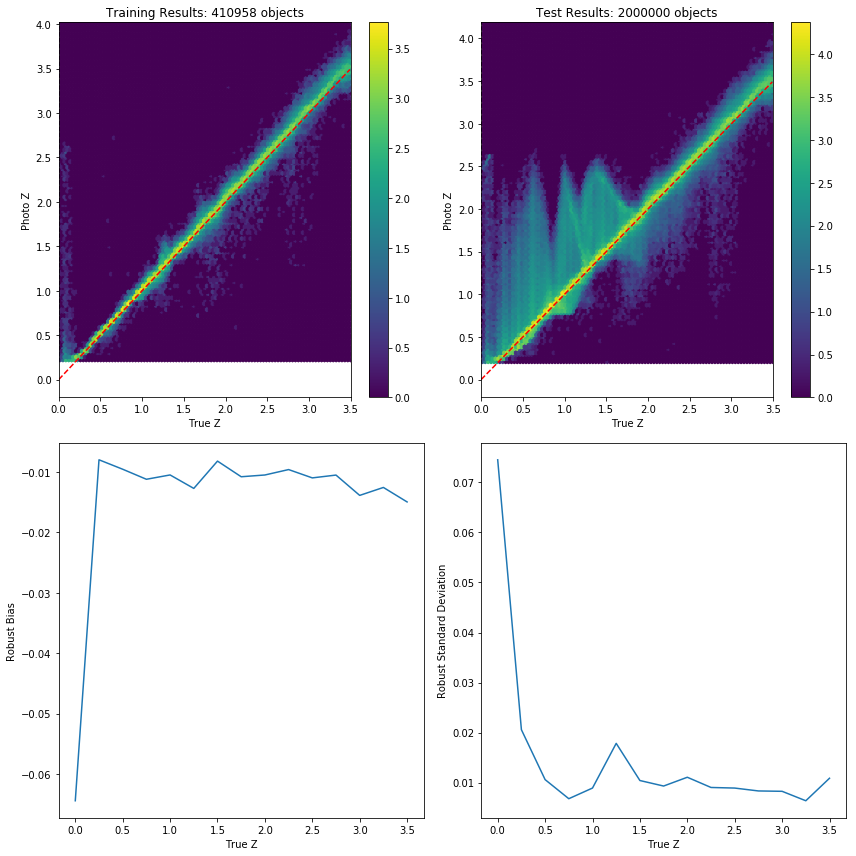

In [31]:
# full
cat_string = '4_group_color_cut_0'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

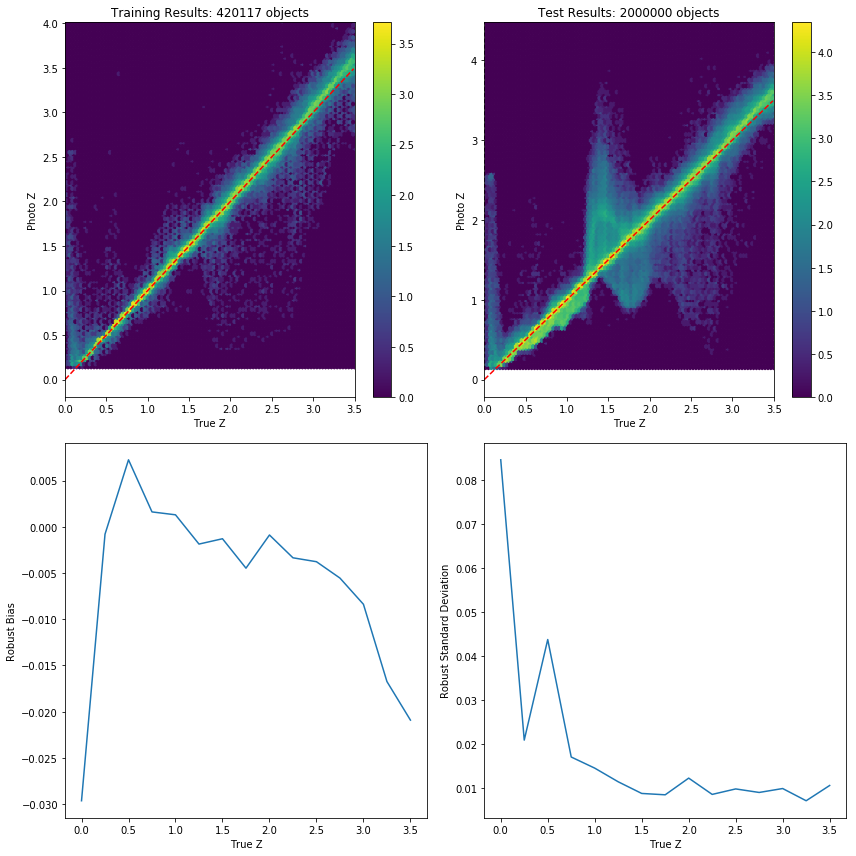

In [35]:
# full
cat_string = 'combined'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

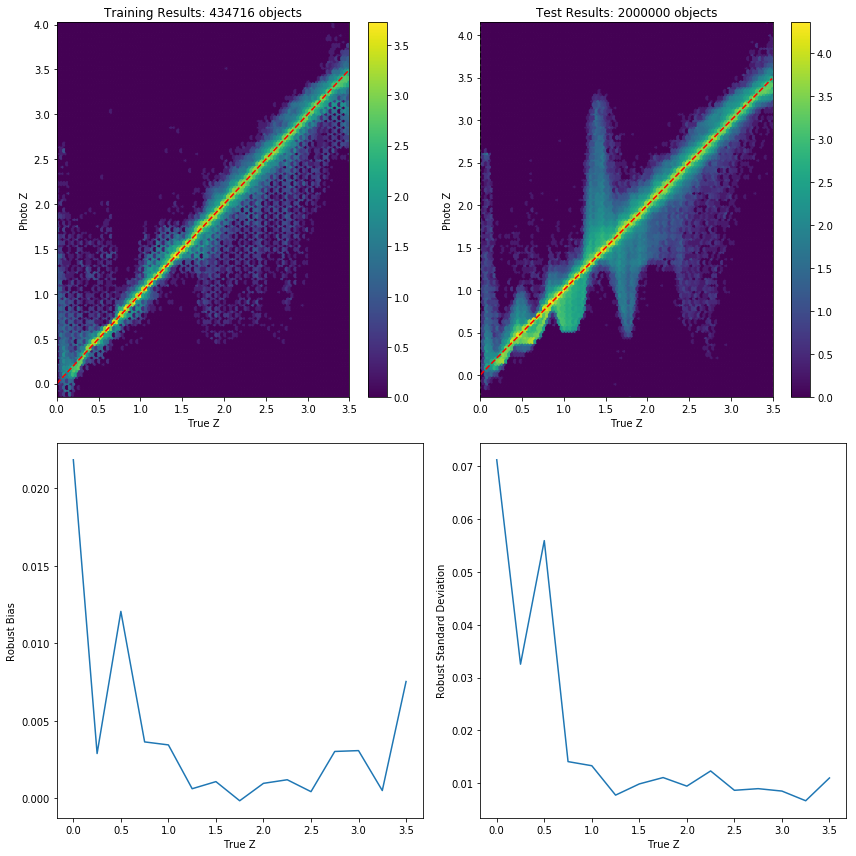

In [57]:
# full
cat_string = 'combined_esp'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

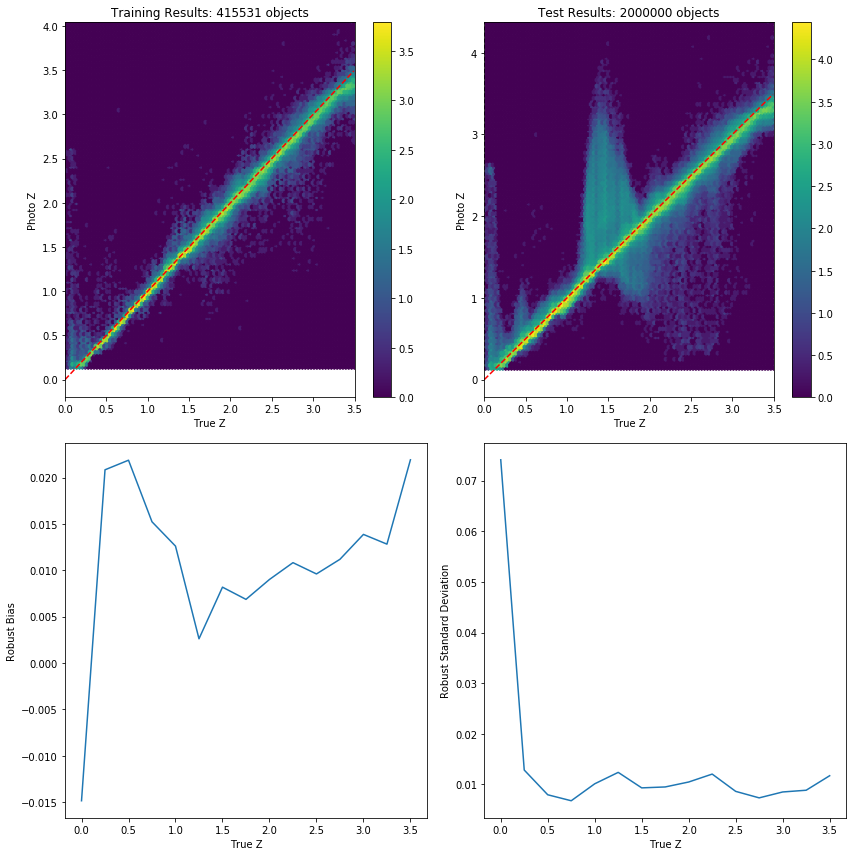

In [112]:
# full
cat_string = 'combined_cut'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

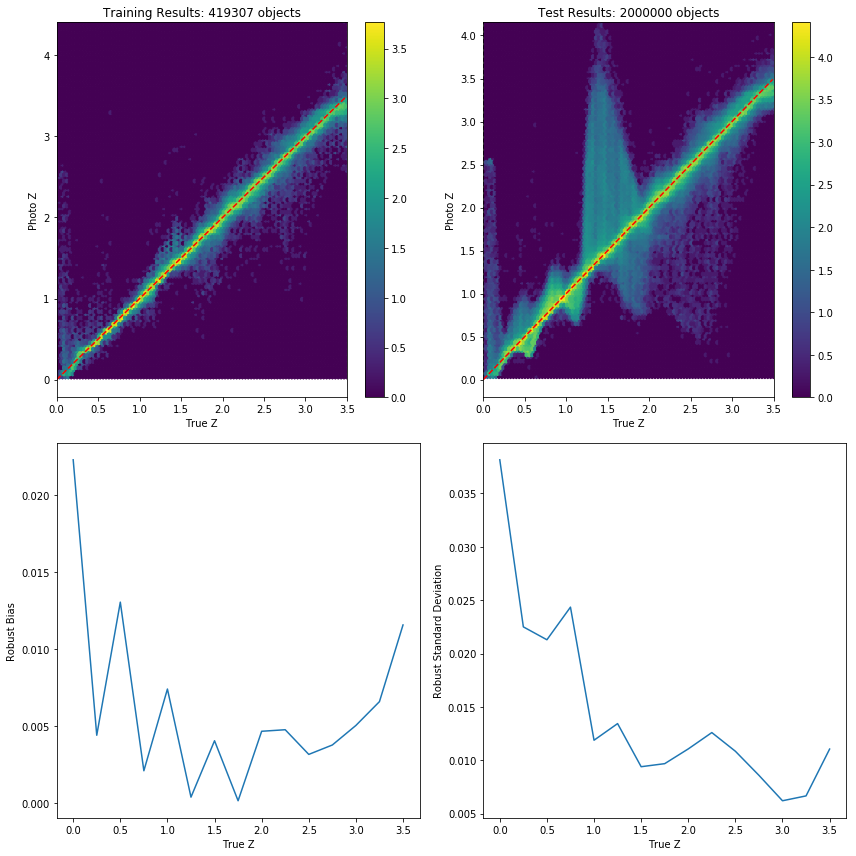

In [149]:
# full
cat_string = 'combined_cut_esp'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

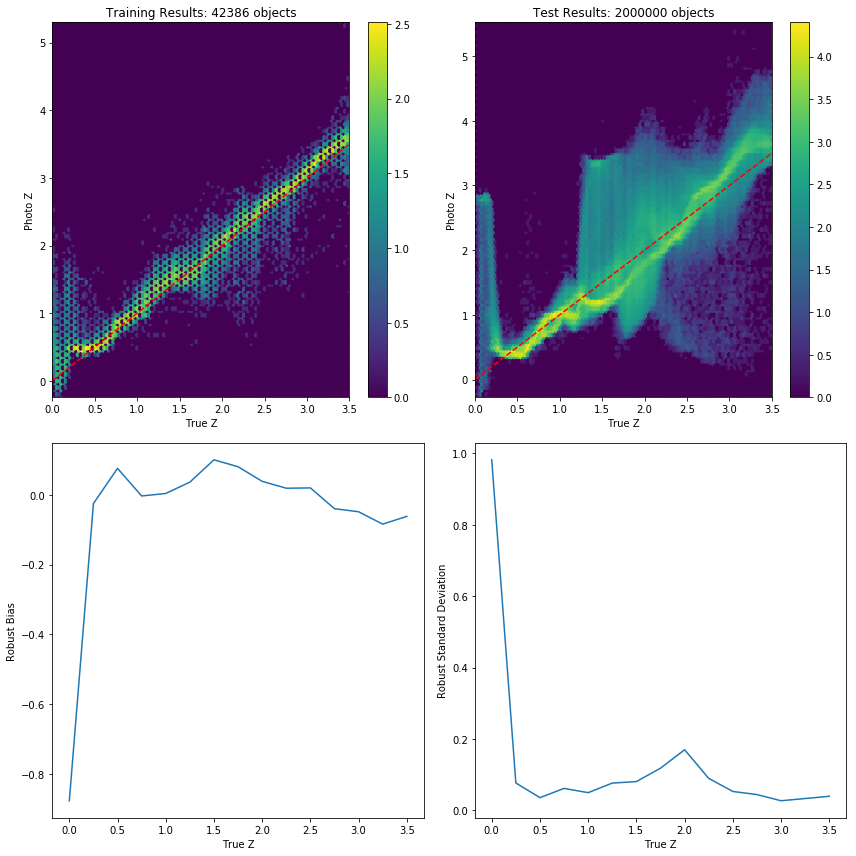

In [38]:
# full
cat_string = 'brown_esp'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

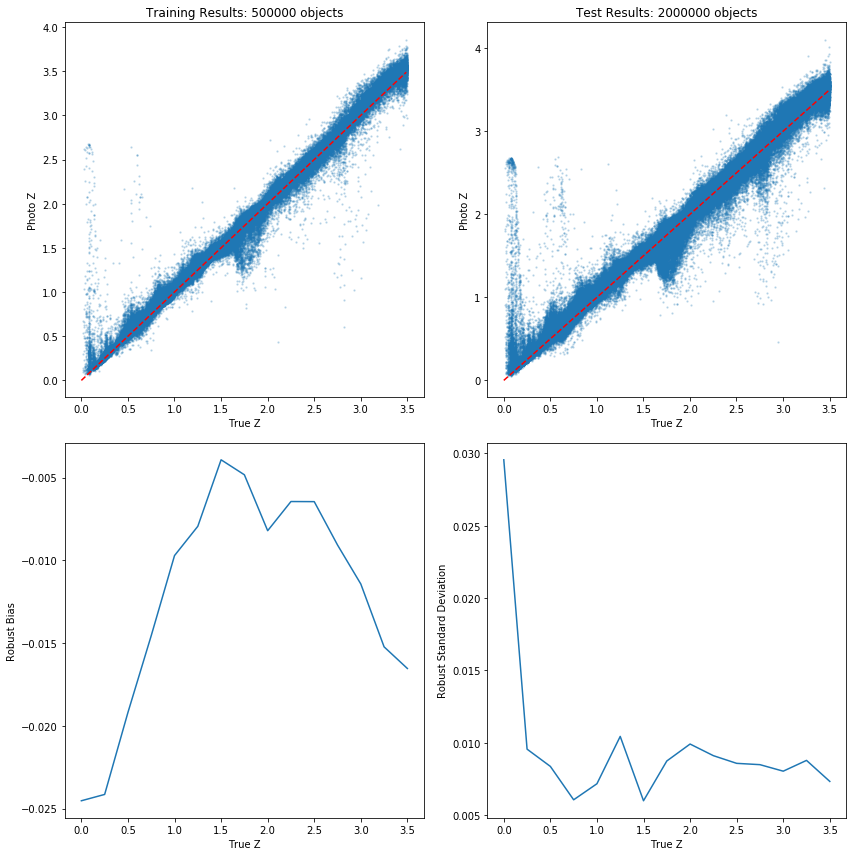

In [29]:
# full
cat_string = 'full'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string, density_plot=False)

### Compare Results

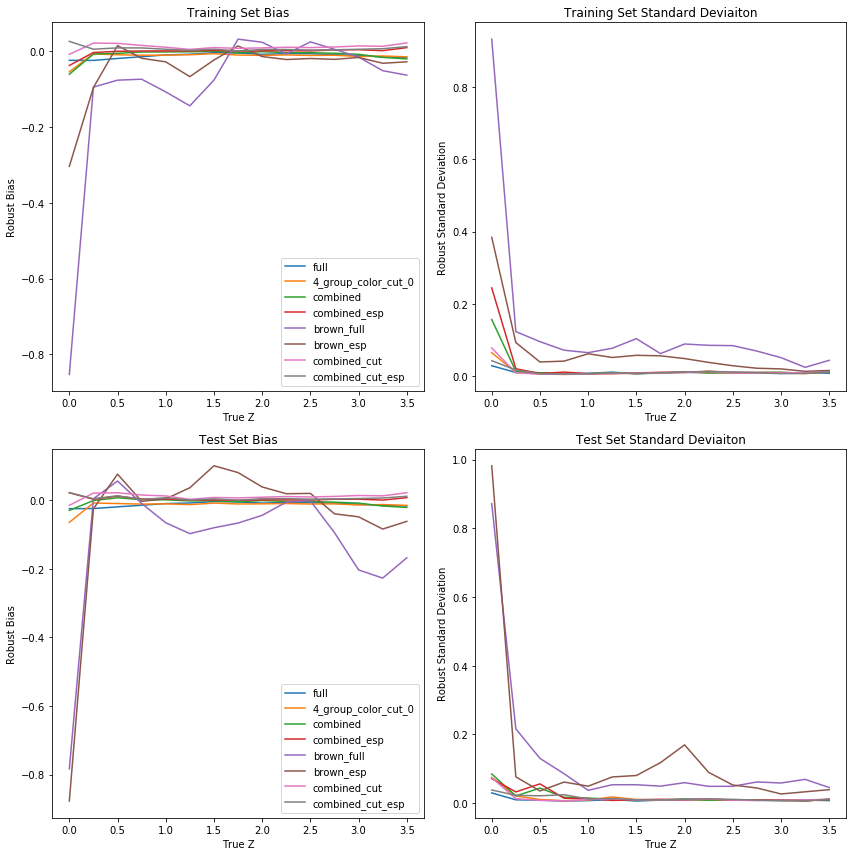

In [150]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

In [161]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined', #'combined_esp',
                   'combined_cut']:#, 
                   #'combined_cut_esp']:#, 'brown_full', 'brown_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

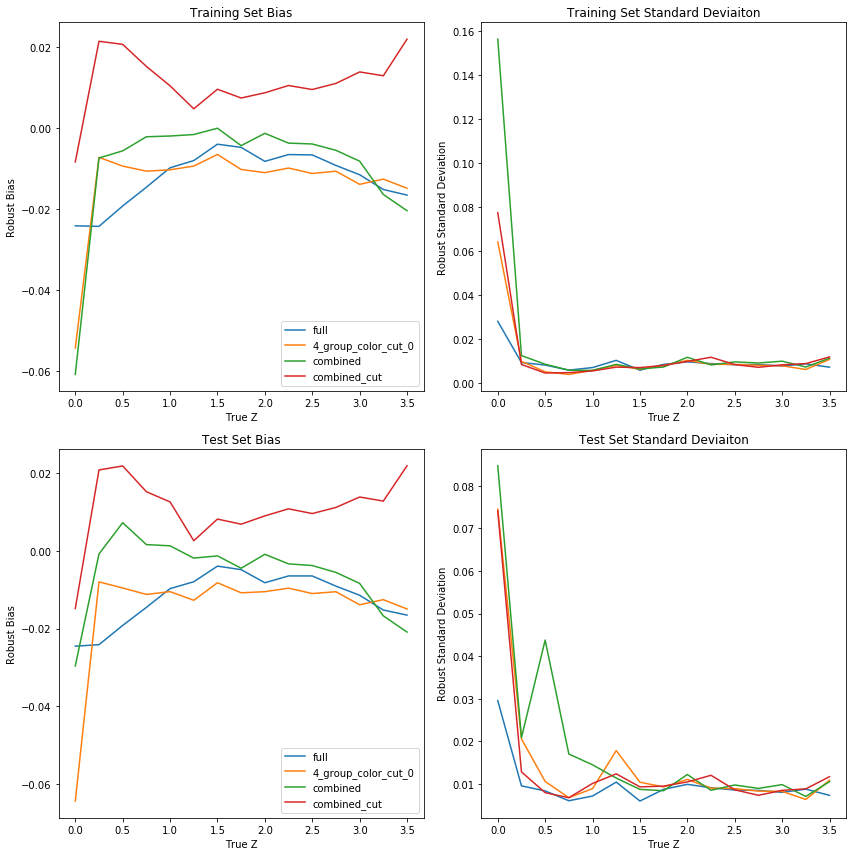

In [162]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

In [153]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined_cut', 'combined_cut_esp']:#, 'brown_full', 'brown_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

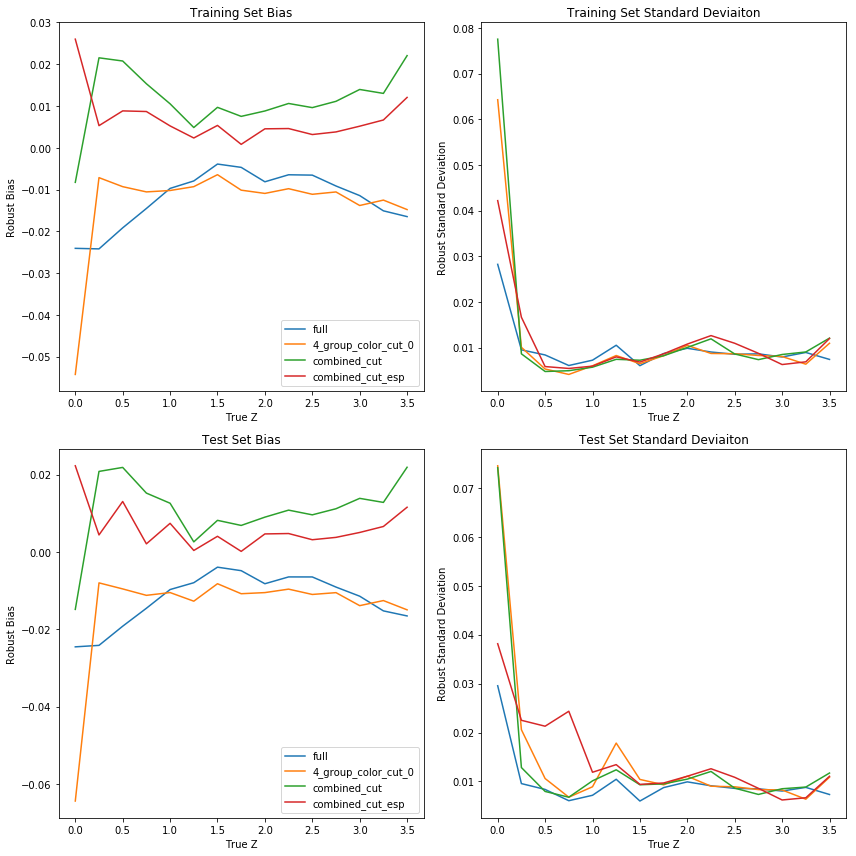

In [154]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

In [155]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined', 
                   'combined_esp', 'combined_cut', 'combined_cut_esp',
                   'brown_full', 'brown_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

#### Find regions where results are missing and compare

In [156]:
# Load color labels
color_labels = np.genfromtxt('../data/test_labels_4_group_color_cut_0.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_colors_df = test_results_dict['4_group_color_cut_0'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_brown_df = test_results_dict['brown_full'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_combined_df = test_results_dict['combined'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_combined_cut_df = test_results_dict['combined_cut'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_combined_cut_esp_df = test_results_dict['combined_cut_esp'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_combined_esp_df = test_results_dict['combined_esp'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_brown_esp_df = test_results_dict['brown_esp'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)

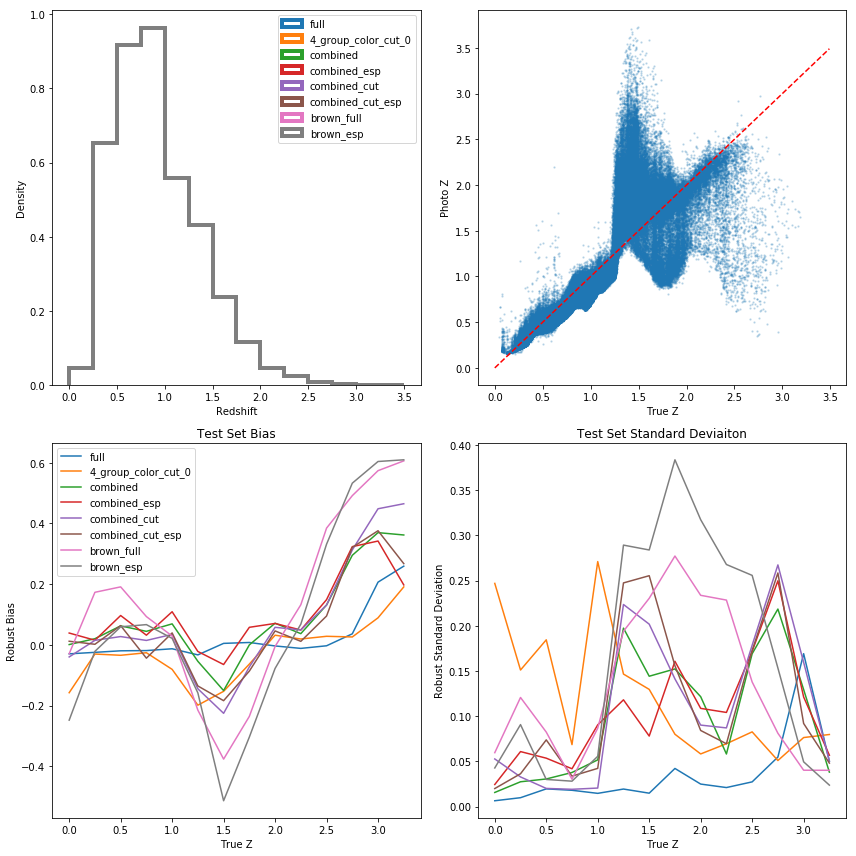

In [157]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df,
                          test_combined_df, test_combined_esp_df, test_combined_cut_df,
                          test_combined_cut_esp_df, 
                          test_brown_df, test_brown_esp_df],
                         ['full', '4_group_color_cut_0', 'combined',
                          'combined_esp', 'combined_cut', 'combined_cut_esp',
                          'brown_full', 'brown_esp'],
                         '../data/compare_color_cut_0.pdf',  scatter_index=2)

In [164]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df,
                          test_combined_df, #test_combined_esp_df, 
                          test_combined_cut_df],
                          #test_combined_cut_esp_df],
                         ['full', '4_group_color_cut_0', 
                          'combined',# 'combined_esp', 
                          'combined_cut'],#, 'combined_cut_esp'],
                         '../data/compare_color_cut_0.pdf',  scatter_index=2)

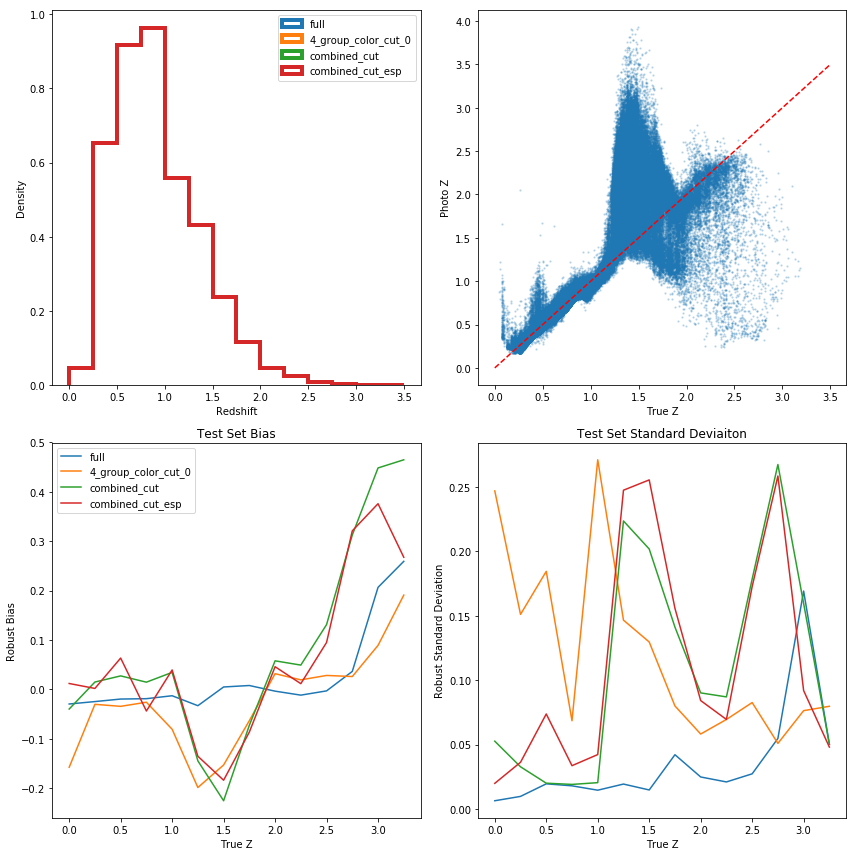

In [158]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df,
                          #test_combined_df, test_combined_esp_df, 
                          test_combined_cut_df,
                          test_combined_cut_esp_df],
                         ['full', '4_group_color_cut_0', 
                          #'combined', 'combined_esp', 
                          'combined_cut', 'combined_cut_esp'],
                         '../data/compare_color_cut_0.pdf',  scatter_index=2)